## Simulate time series using fitted ARIMA model:

### Using sktime and statsforecast

In [ ]:
#-----------------IMPORTS-----------------#
from numba import njit
import pandas as pd #we separately import pandas to read data from a csv file
import numpy as np

#-----------------DATA-----------------#
#1min EURGBP data
url = "https://onedrive.live.com/download?resid=4E16D53638D067A9%21339325&authkey=!AHOCBUokDjDiCc8"

#1 second EURGBP data
#url = "https://onedrive.live.com/download?resid=4E16D53638D067A9%21339754&authkey=!ACcJZZPFqOmKVUY"

data_downloaded = pd.read_csv(url, parse_dates = True, index_col=0) #it's a time series data, so I'm setting the index to be the first column
data_downloaded = data_downloaded.asfreq('T')
data_downloaded.ffill(inplace=True)
print(data_downloaded.index.freq)
#close = data_downloaded["close"].to_numpy() #We transform the close prices into a numpy array

In [ ]:
### Fit using sktime
from sktime.forecasting.arima import AutoARIMA
forecaster = AutoARIMA(maxiter=100, stepwise=False, n_jobs=-1)
forecaster.fit(data_downloaded["close"])
forecaster.get_fitted_params()

In [ ]:
### Fitted SARIMA parameters:
{'intercept': -5.398901140173307e-08,
 'ma.L1': -0.1042188993634203,
 'ma.L2': -0.029764115450367442,
 'ma.L3': -0.002917953581047072,
 'ma.L4': 0.004290940137585559,
 'ma.L5': -0.012028812812397361,
 'sigma2': 2.956406656496939e-09,
 'order': (0, 1, 5),
 'seasonal_order': (0, 0, 0, 1),
 'aic': -5639035.469712176,
 'aicc': -5639035.469378472,
 'bic': -5638960.403255404,
 'hqic': -5639013.861095114}

In [ ]:
import statsmodels.api as sm

p, d, q = 0, 1, 5

model = sm.tsa.ARIMA(data_downloaded["close"], order=(p, d, q))
model_fit = model.fit()

In [ ]:
model_fit.summary() #it's identical to the one calculated by sktime

In [ ]:
simulated_series = model_fit.simulate(nsimulations=len(data_downloaded["close"]))
print(simulated_series)

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plot 1
axes[0].plot(data_downloaded.index, data_downloaded['close'])
axes[0].set_title('Original Data')
axes[0].set_xlabel('Timestamp')
axes[0].set_ylabel('Close Price')

# Plot 2
axes[1].plot(data_downloaded.index, simulated_series)
axes[1].set_title('Simulated Data')
axes[1].set_xlabel('Timestamp')
axes[1].set_ylabel('Close Price')

plt.tight_layout()
plt.show()

### Simulate Moving Average Model manually with for loop

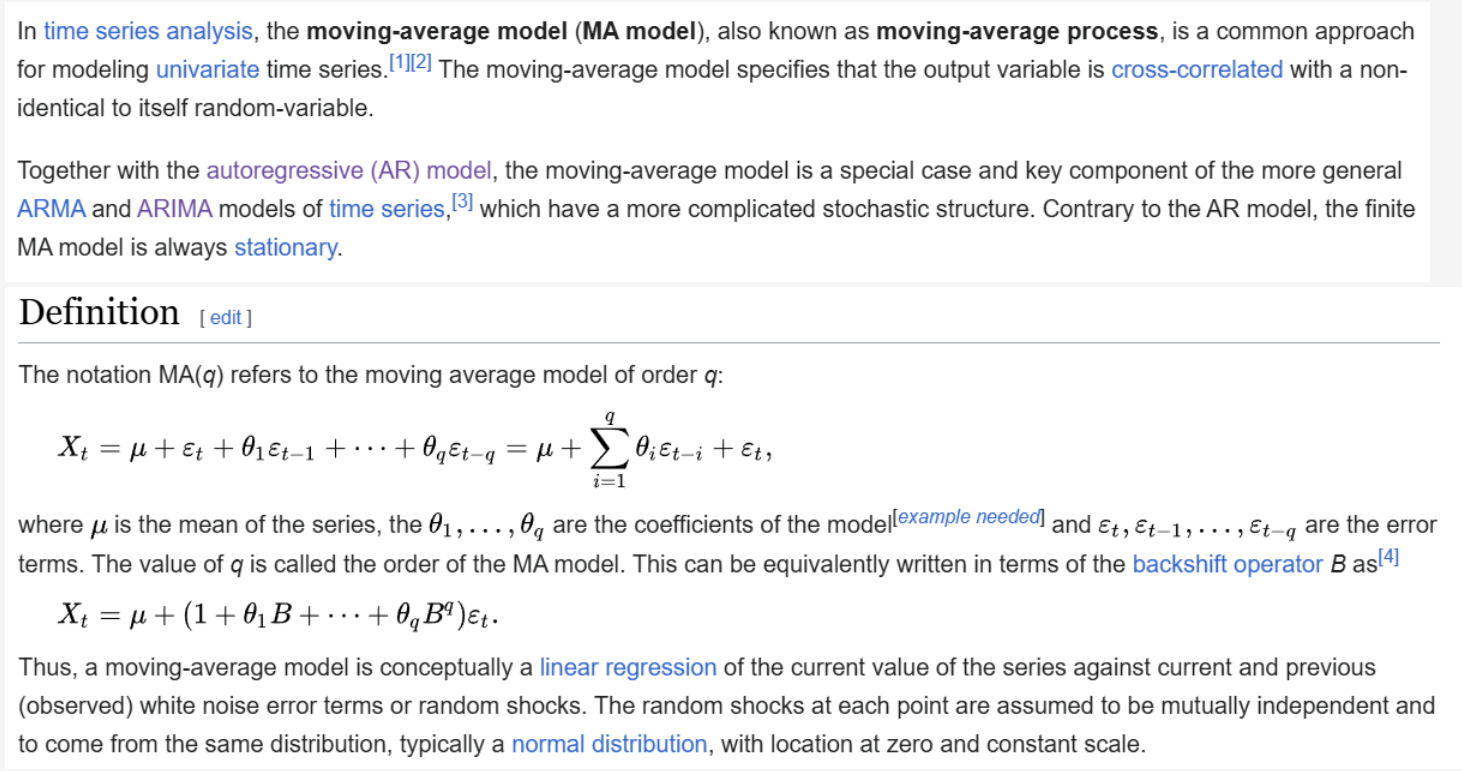

In [ ]:
### Fitted SARIMA parameters:
{'intercept': -5.398901140173307e-08,
 'ma.L1': -0.1042188993634203,
 'ma.L2': -0.029764115450367442,
 'ma.L3': -0.002917953581047072,
 'ma.L4': 0.004290940137585559,
 'ma.L5': -0.012028812812397361,
 'sigma2': 2.956406656496939e-09,
 'order': (0, 1, 5),
 'seasonal_order': (0, 0, 0, 1),
 'aic': -5639035.469712176,
 'aicc': -5639035.469378472,
 'bic': -5638960.403255404,
 'hqic': -5639013.861095114}

In [ ]:
# yt = media(eurgbp) + errore(0, 2.956406656496939e-09) + -0.1042188993634203 * errore(1) + -0.029764115450367442 * errore(2) + 
#      -0.002917953581047072 * errore(3) + 0.004290940137585559 * errore(4) + -0.012028812812397361 * errore(5)

In [1]:
import numpy as np
import pandas as pd

#-----------------DATA-----------------#
#1min EURGBP data
url = "https://onedrive.live.com/download?resid=4E16D53638D067A9%21339325&authkey=!AHOCBUokDjDiCc8"

data_downloaded = pd.read_csv(url, parse_dates = True, index_col=0) #it's a time series data, so I'm setting the index to be the first column
close = data_downloaded["close"].to_numpy() #We transform the close prices into a numpy array

In [2]:
import numpy as np
import pandas as pd
from numba import njit

@njit(fastmath = True) #we use the njit decorator to speed up the function
def GenerateSimulation(data):
    yt = np.zeros(len(data))
    yt[0] = np.mean(data)
    error_terms = np.zeros(len(data))
    error_terms[0] = np.random.normal(0, 2.956406656496939e-09)
    
    for i in range(1,len(yt)):
        error_terms[i] = np.random.normal(0, 2.956406656496939e-09)
        yt[i] =  yt[i-1] + error_terms[i] + -0.1042188993634203 * error_terms[i-1] + -0.029764115450367442 * error_terms[i-2] + -0.002917953581047072 * error_terms[i-3] + 0.004290940137585559 * error_terms[i-4] + -0.012028812812397361 * error_terms[i-5]

    return yt

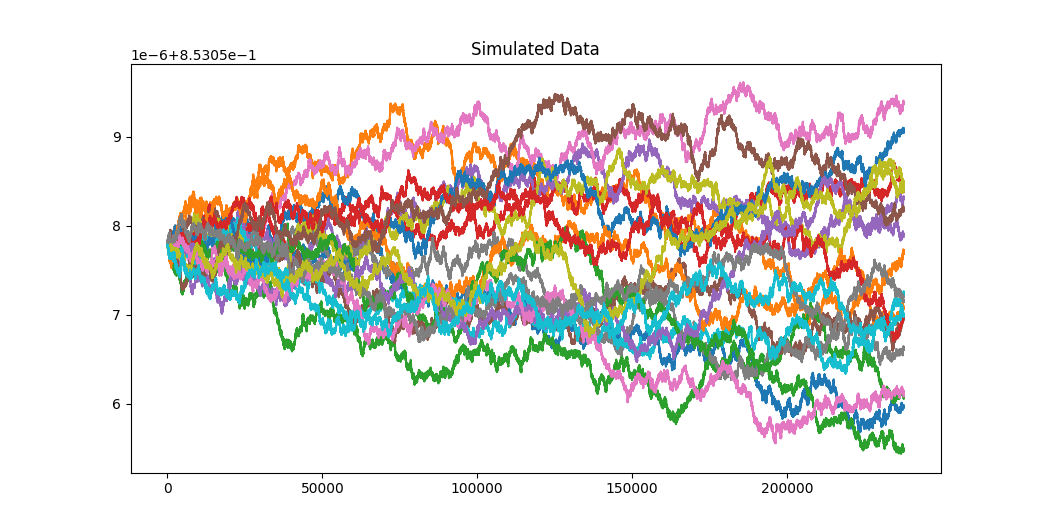

In [5]:
### Now I need to simulate thousands of time series based on that model; I will use the same error terms for all of them
@njit(fastmath = True) #we use the njit decorator to speed up the function
def ThousandSimulations(data, number_simulations):
    simulated_series_matrix = np.zeros((len(data), number_simulations))
    for i in range(number_simulations):
        simulated_series_matrix[:,i] = GenerateSimulation(data)

    return simulated_series_matrix

sim_prices = ThousandSimulations(close, 10)

want_to_plot = True
if want_to_plot == True:
    import matplotlib.pyplot as plt
    %matplotlib widget
    plt.plot(sim_prices)
    plt.title("Simulated Data")
    plt.show()